In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy.physics.units as u
import sympy as sp
import numpy as np
import logging as log
import functools
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
pd.set_option('display.max_columns', None)
%matplotlib inline
from IPython.display import display, HTML

import sys, os, importlib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import miptlabs as ml
importlib.reload(ml)

importlib.reload(log)
log.basicConfig(level=log.INFO, format='LOG %(message)s', stream=sys.stdout)

sp.Basic.__str__=lambda expr, **settings:ml.PQStrPrinter(settings).doprint(expr)

sp.__version__

'1.1.2.dev'

In [3]:
# Рассчитываем частоты, которые нужно выставить (примерно), чтобы получилось 5, 6 и 7 резонансов
mu = ml.PQ(29*10**(-3)*u.kg/u.mol, is_const=True)
T = ml.PQ(ml.celsium_to_kelvins(22.6), sigma=0.2*u.kelvins) # Комнатная
delta_L_max = ml.PQ(23*u.cm, sigma=0.1*u.cm)
v_sound_estim = ml.PQ(330*u.m/u.s, sigma=1*u.m/u.s)
f_s = [(v_sound_estim*n/delta_L_max/2).repr_as(u.hz) for n in [5, 6, 7]]
f_s

[3587±19 Hz (0.53%), 4304±23 Hz (0.53%), 5022±27 Hz (0.53%)]

344.7±0.5 m/s (0.16%)
1.401±0.005  (0.33%)
346.7±0.5 m/s (0.14%)
1.417±0.004  (0.29%)
351±4 m/s (1.00%)
1.457±0.029  (2.0%)


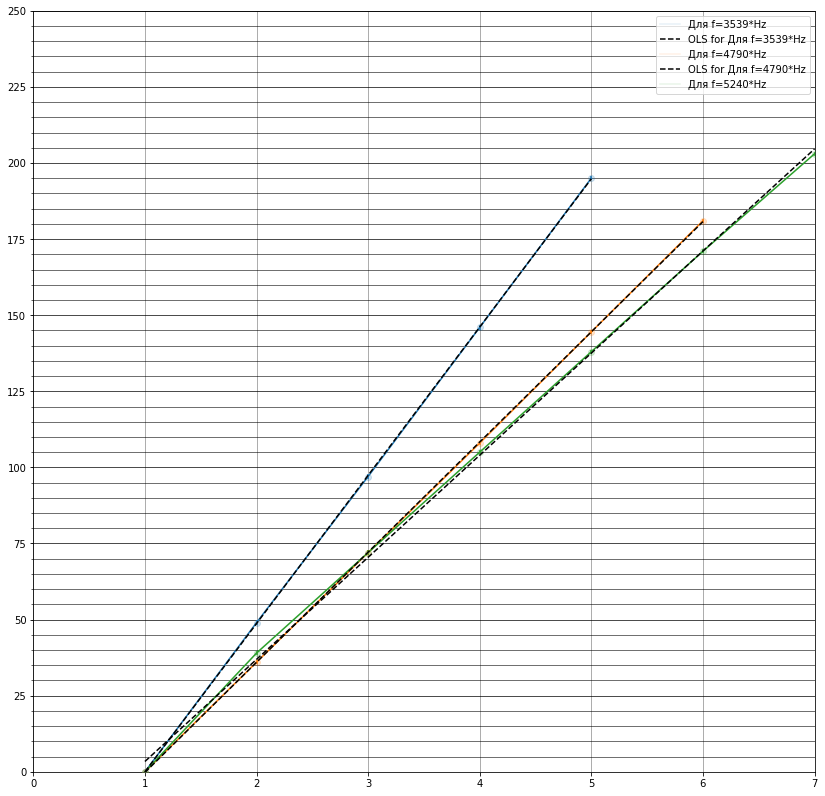

In [4]:
# Частоты
f_s = np.array([ml.PQ(val*u.hz, sigma=0.01*u.hz) for val in 
                     [3539, 4790, 5240]])
# Длины трубы (по шкале)
L_s = [ np.array([ml.PQ(val*u.mm, sigma=0.5*u.mm) for val in 
                     [20, 69, 117, 166, 215]]),
        np.array([ml.PQ(val*u.mm, sigma=0.5*u.mm) for val in 
                     [11, 47, 83, 119, 155.5, 192]]),
        np.array([ml.PQ(val*u.mm, sigma=0.5*u.mm) for val in 
                     [23, 62, 95, 128, 161, 194, 226]])]

plt.figure(figsize=(14, 14))
for L, f in zip(L_s, f_s):
    plt.xlim(0, 7)
    plt.ylim(0, 250)
    
    grid = np.arange(1, len(L)+1, 1)
    ml.plt_pq(grid, (L-L[0]), label='Для f=%s'%f.val, ols=True, grid_y=25, grid_x=(1, 0))
    
    ols_coefs, ols_errors = ml.OLS(grid, L)
    #print(ols_coefs, ols_errors)
    lambd = ml.PQ(2*ols_coefs[0]*L[0].dim, sigma=2*ols_errors[0]*L[0].dim)
    v_sound = (lambd*f).repr_as(u.m/u.s)
    print(v_sound)
    gamma = (mu/(u.R*T)*v_sound**2).repr_as(1)
    print(gamma)
plt.show()


(307.70±2.20)*10^3 mm/s (0.73%)
1.123±0.016  (1.5%)
(356.70±2.20)*10^3 mm/s (0.63%)
1.417±0.018  (1.3%)
(287.80±2.20)*10^3 mm/s (0.78%)
0.867±0.013  (1.6%)


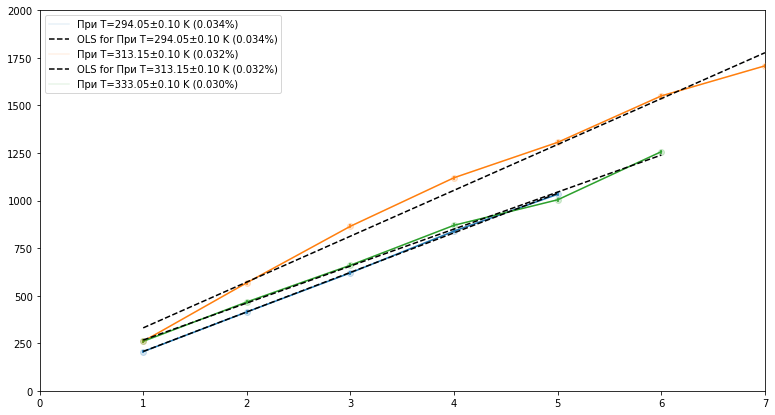

In [5]:
# Длина трубы
L = ml.PQ(740*u.mm, sigma=0.5*u.mm) 
# Температуры
T_s = [ml.PQ(ml.celsium_to_kelvins(20.9), sigma=0.1*u.kelvins),
       ml.PQ(ml.celsium_to_kelvins(40.0), sigma=0.1*u.kelvins),
       ml.PQ(ml.celsium_to_kelvins(59.9), sigma=0.1*u.kelvins)]
# Частоты
f_s = [np.array([ml.PQ(val*u.hz, sigma=10*u.hz, dim=u.hz) for val in 
                     [206.1, 414.3, 620.0, 839.6, 1033.0]]),
       np.array([ml.PQ(val*u.hz, sigma=10*u.hz, dim=u.hz) for val in 
                     [260, 568, 865, 1120, 1306, 1550, 1708]]),
       np.array([ml.PQ(val*u.hz, sigma=10*u.hz, dim=u.hz) for val in 
                     [260.0, 467, 660, 870, 1004, 1257]])]

plt.figure(figsize=(13, 7))
plt.xlim(0, 7)
plt.ylim(ymin=0, ymax=2000)
for T, f in zip(T_s, f_s):
    grid = np.arange(1, len(f)+1, 1)
    ml.plt_pq(grid, f, ols=True, label='При T=%s'%T)
    ols_coefs, ols_errors = ml.OLS(grid, f)
    
    ols_errors = [4/np.sqrt(7),0]
    v_sound = ml.PQ((2*L*ols_coefs[0]/u.s).val, sigma=(2*L*ols_errors[0]/u.s).val, dim=u.mm/u.s)
    print(v_sound)
    gamma = (mu/(u.R*T)*v_sound**2).repr_as(1)
    print(gamma)
plt.grid()
plt.show()